In [1]:
from bs4 import BeautifulSoup
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVC
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer



In [2]:
# Scraping review of Easyjet
data = []
# Set Trustpilot page numbers to scrape here
from_page = 1
to_page = 200 # 667

for i in range(from_page, to_page + 1):
    response = requests.get(f"https://uk.trustpilot.com/review/www.easyjet.com?page={i}")
    web_page = response.text
    soup = BeautifulSoup(web_page, "html.parser")

    for e in soup.select('article'):
        data.append({
            'review_title':e.h2.text,
            'review_date_original': e.select_one('[data-service-review-date-of-experience-typography]').text.split(': ')[-1],
            'review_rating':e.select_one('[data-service-review-rating] img').get('alt'),
            'review_text': e.select_one('[data-service-review-text-typography]').text if e.select_one('[data-service-review-text-typography]') else None,
            'page_number':i
        })

easyjet = pd.DataFrame(data)

In [3]:
easyjet.head(10)

,review_title,review_date_original,review_rating,review_text,page_number
0,Hope you never have to cancel!,05 December 2024,Rated 1 out of 5 stars,We have travelled Easyjet frequently. Unfortun...,1
1,No refund for huge delays,05 November 2024,Rated 2 out of 5 stars,Our flight from Paris to London was delayed by...,1
2,Knowledgeable,05 December 2024,Rated 4 out of 5 stars,"Advisors helpful, wish the website was easier ...",1
3,It was very pleasant to to talk but the rezult...,05 December 2024,Rated 1 out of 5 stars,Everyting including the date of conversation w...,1
4,Brilliant service as always,05 December 2024,Rated 4 out of 5 stars,The service from the staff member was superb. ...,1
5,Chatting to an agent online isn't what…,05 December 2024,Rated 5 out of 5 stars,Chatting to an agent online isn't what I was l...,1
6,Agent was super rude and kept pushing…,05 December 2024,Rated 1 out of 5 stars,Agent was super rude and kept pushing out the ...,1
7,Nothing Easy,05 October 2024,Rated 1 out of 5 stars,They use just chat bot and phone services only...,1
8,Live chat was super fast,05 December 2024,Rated 5 out of 5 stars,Live chat sorted my query out quickly. The rob...,1
9,Disappointing outcome...,04 December 2024,Rated 3 out of 5 stars,Xola the cutsomer advisor was very polite and ...,1


In [4]:
# Load data
data = easyjet.copy()
data.head(2) ; data.shape

(3020, 5)

In [5]:
# Data preprocessing
def preprocess_data(data):
    data['review_rating_num'] = data['review_rating'].str.extract('(\d+)').astype(int)
    data['sentiment'] = data['review_rating_num'].apply(lambda x: 'Positive' if x > 3 else 'Neutral' if x == 3 else 'Negative')
    data['clean_text'] = data['review_text'].str.replace('[^a-zA-Z]', ' ', regex=True).str.lower()
    return data

data = preprocess_data(data)
data.head(2)

,review_title,review_date_original,review_rating,review_text,page_number,review_rating_num,sentiment,clean_text
0,Hope you never have to cancel!,05 December 2024,Rated 1 out of 5 stars,We have travelled Easyjet frequently. Unfortun...,1,1,Negative,we have travelled easyjet frequently unfortun...
1,No refund for huge delays,05 November 2024,Rated 2 out of 5 stars,Our flight from Paris to London was delayed by...,1,2,Negative,our flight from paris to london was delayed by...


In [6]:
# Split data
X = data['clean_text']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# TF-IDF Vectorization

# Replace None or NaN values with empty strings
X_train = X_train.fillna("")
X_test = X_test.fillna("")

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

In [8]:
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)
lr_predictions = lr_model.predict(X_test_tfidf)

In [9]:
# Support Vector Machine
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)
svm_predictions = svm_model.predict(X_test_tfidf)

In [10]:
# Tokenization for LSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=200)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=200)

In [11]:
# LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=200),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Convert y_train and y_test to numeric labels
def encode_labels(y):
    return y.map({'Negative': 0, 'Neutral': 1, 'Positive': 2}).values

encoded_y_train = encode_labels(y_train)
encoded_y_test = encode_labels(y_test)

lstm_model.fit(X_train_seq, encoded_y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)
lstm_predictions = np.argmax(lstm_model.predict(X_test_seq), axis=1)

Epoch 1/5


c:\users\amfua\documents\python_projects\project_1\project_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.6229 - loss: 0.7816 - val_accuracy: 0.8285 - val_loss: 0.4611
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.8677 - loss: 0.3885 - val_accuracy: 0.8864 - val_loss: 0.3287
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.9405 - loss: 0.2123 - val_accuracy: 0.8864 - val_loss: 0.3695
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9444 - loss: 0.1977 - val_accuracy: 0.8988 - val_loss: 0.3264
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9654 - loss: 0.1339 - val_accuracy: 0.9008 - val_loss: 0.3202
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


In [12]:
# Decode numeric labels back to original sentiments
def decode_labels(y):
    mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return pd.Series(y).map(mapping)

lstm_predictions_decoded = decode_labels(lstm_predictions)

In [13]:
# Evaluation
print("Logistic Regression:\n", classification_report(y_test, lr_predictions))
print("SVM:\n", classification_report(y_test, svm_predictions))
print("LSTM:\n", classification_report(y_test, lstm_predictions_decoded))

Logistic Regression:
               precision    recall  f1-score   support

    Negative       0.89      0.87      0.88       269
     Neutral       0.00      0.00      0.00        14
    Positive       0.89      0.95      0.92       321

    accuracy                           0.89       604
   macro avg       0.59      0.61      0.60       604
weighted avg       0.87      0.89      0.88       604

SVM:
               precision    recall  f1-score   support

    Negative       0.89      0.91      0.90       269
     Neutral       0.00      0.00      0.00        14
    Positive       0.92      0.94      0.93       321

    accuracy                           0.90       604
   macro avg       0.60      0.62      0.61       604
weighted avg       0.88      0.90      0.89       604

LSTM:
               precision    recall  f1-score   support

    Negative       0.89      0.88      0.89       269
     Neutral       0.00      0.00      0.00        14
    Positive       0.89      0.95      0

c:\users\amfua\documents\python_projects\project_1\project_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\amfua\documents\python_projects\project_1\project_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\amfua\documents\python_projects\project_1\project_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [14]:
# Compare models
def compare_models():
    models = ['Logistic Regression', 'SVM', 'LSTM']
    accuracies = [
        accuracy_score(y_test, lr_predictions),
        accuracy_score(y_test, svm_predictions),
        accuracy_score(y_test, lstm_predictions_decoded)
    ]
    
    results = pd.DataFrame({
        'Model': models,
        'Accuracy': accuracies
    })
    
    return results

results = compare_models()
print(results)

                 Model  Accuracy
0  Logistic Regression  0.890728
1                  SVM  0.903974
2                 LSTM  0.894040


C:\Users\amfua\AppData\Local\Temp\ipykernel_3608\724019931.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results, palette='viridis')


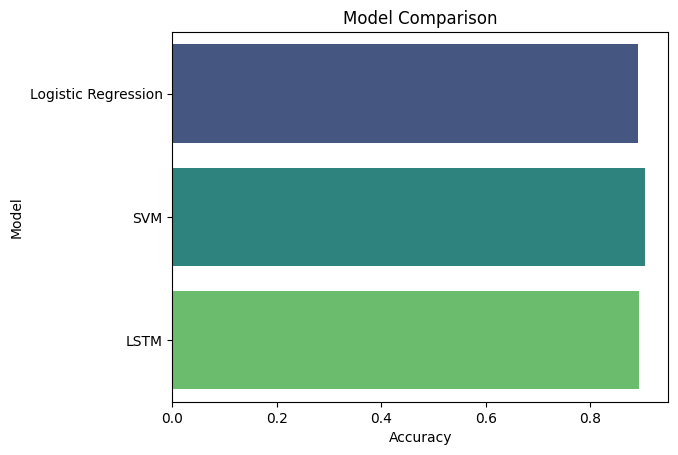

In [15]:
# Visualize model comparison
sns.barplot(x='Accuracy', y='Model', data=results, palette='viridis')
plt.title('Model Comparison')
plt.show()

In [16]:
from wordcloud import WordCloud

# Filter reviews
positive_reviews = X_test[y_test == 'Positive']
negative_reviews = X_test[y_test == 'Negative']

# Generate WordClouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

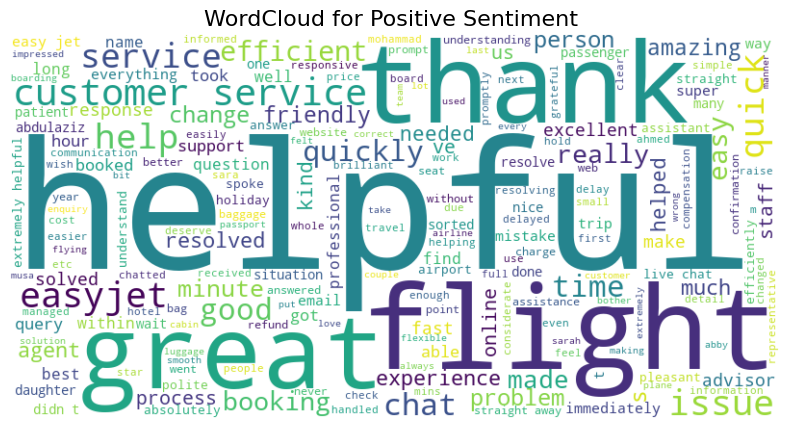

In [17]:
# Positive sentiment WordCloud
generate_wordcloud(positive_reviews, "WordCloud for Positive Sentiment ")

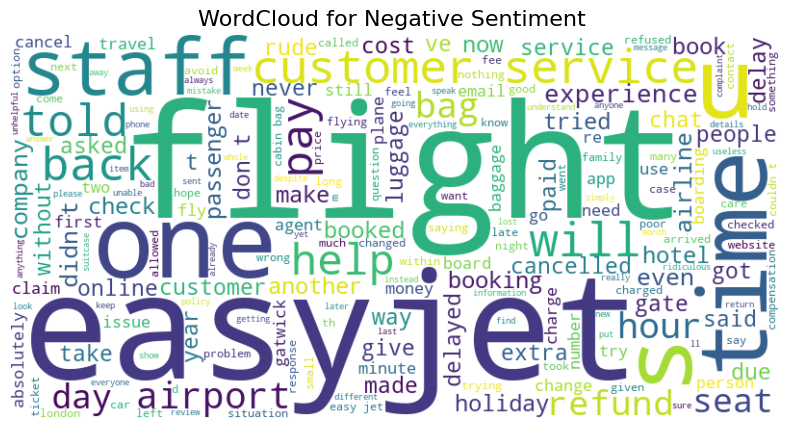

In [18]:
# Negative sentiment WordCloud
generate_wordcloud(negative_reviews, "WordCloud for Negative Sentiment ")


C:\Users\amfua\AppData\Local\Temp\ipykernel_3608\242519172.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='sentiment', palette='viridis')


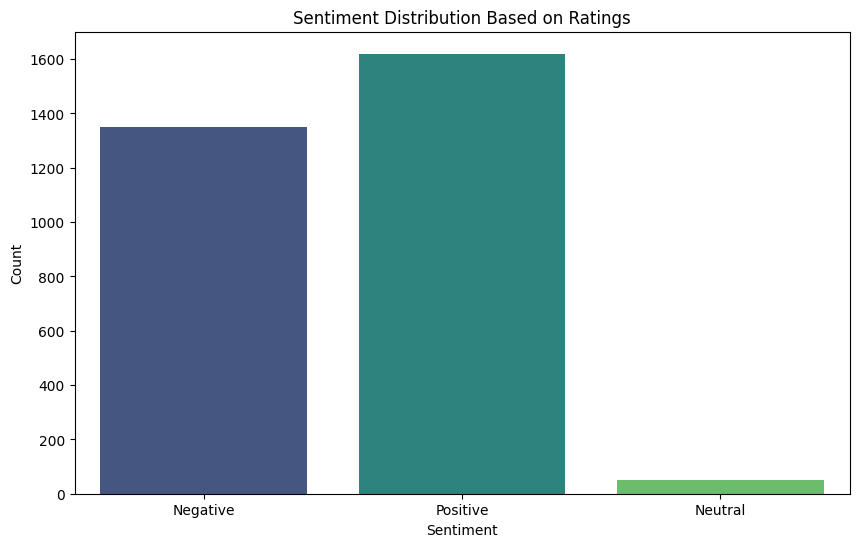

In [19]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='sentiment', palette='viridis')
plt.title('Sentiment Distribution Based on Ratings')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()